In [1]:
import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt
from astropy.io import ascii
from matplotlib.patches import Rectangle

import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt
from astropy.io import ascii

from matplotlib.patches import Rectangle
from astropy.coordinates import Angle, SkyCoord
from regions import CircleSkyRegion, PixCoord, CirclePixelRegion
import astropy.units as u
from astropy.io import fits
from astropy.utils.data import download_file
from astropy.table import Table
from matplotlib.patches import Ellipse
from regions import EllipseSkyRegion

#panstarrs redshift catalogue

from __future__ import print_function
#import mastcasjobs
from astropy.io import ascii
from astropy.table import Table
from astropy import coordinates, units
import numpy as np
import os
import re
import getpass
import requests 
from urllib.parse import quote as urlencode 
from urllib.request import urlretrieve 
import http.client as httplib
     
from astropy.io import ascii 
from astropy.table import Table 
from astropy import coordinates, units

from astropy.wcs import WCS
#from regions import PixCoord, PolygonPixelRegion
from astropy.visualization import ZScaleInterval
from astropy.cosmology import Planck18 as cosmo

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

In [2]:
def F_nu(t_p,nu_p,F_nup,nu_sed):
    '''Calculates a Synchrotron Self-Absorbed Spectrum for given input parameters.
     axs
    Parameters:
    t_p (days): Time of SSA peak - should be single number
    nu_p (GHz): Frequency of SSA peak - should be single number
    F_nup (mJy): Flux of SSA peak - should be single number
    nu (GHz): Frequencies at which you want the SSA spectrum to be calculated at. Likely an array.
    
    Outputs:
    Fnu (mJy): the flux of the SSA. This is an array with values associated with each value of input array nu.
    '''
    
    m = 0.88 #using stAandard model m = (n-3)/(n-2)
    p = 3.0 #using standard model
    a = (2*m)+0.5
    b = (p+5-(6*m))/2
    t=t_p
    Fnu = F_nup*1.582*(t/t_p)**a*(nu_sed/nu_p)**(5/2)*(1-np.exp(-(t/t_p)**(-(a+b))*(nu_sed/nu_p)**(-(p+4)/2)))
    
    return Fnu


def SSA_props(t_p,nu_p,F_nup,D_L,f=0.5,alpha=1,vw=100,epsilon_b=0.1):
    '''Calculates Synchroton Self-Absorption properties for given input parameters.
    
    Inputs:
    t_p (days): Time of SSA peak - likely a single number
    nu_p (GHz): Frequency of SSA peak - likely a single number
    F_nup (mJy): Flux of SSA peak - likely a single number
    D (Mpc): distance to SN - likely a single number,while D_L is the luminosity distance
    f (unitless): filling factor (fraction of emitting region). default is 0.5
    alpha (unitless): ratio charged particles to magnetic field (epsilon_e/epsilon_b). default 1
    v_w (km/s): wind speed. default = 100
    epsilon_b (unitless): fraction of shock energy into B-fields. default = 0.1
    
    Outputs:
    R (cm): radius of material 
    B : magnetic field flux
    E : intermal energy of emitting material
    v (km/s): expansion velocity of material
    M (1d-5 solar masses per year): inferred mass loss rate of progenitor'''
     #angular distance
    D = D_L/((1+z)**2)

    #Radius
    R = 4.0e14*(alpha)**(-1./19.)*(f/0.5)**(-1./19.)*(F_nup)**(9./19.)*(D)**(18./19.)*(nu_p/5.)**(-1)

    # Magnetic field flux
    B = 1.1*(alpha)**(-4/19)*(f/0.5)**(-4/19)*(F_nup)**(-2/19)*(D)**(-4/19)*(nu_p/5)

    #Internal energy of the emitting material
    E = (1/epsilon_b)*((B**2)/(8* 3.142))*((4*3.142*f*R**3)/3.)

    #expansion velocity in km/s
    v = (R/t_p)*1.1574e-10

    #pre-explosion mass-loss in 1e-5 solar mass per year --wrong
    #M = 1.0*(alpha)**(-8/19)*(epsilon_b/0.1)*(f/0.5)**(-8/19)*(F_nup)**(-4/19)*(D)**(-4/19)*(nu_p/5)*(t_p/10)*(vw/1000)
    
    #pre-explosion mass-loss in 1e-5 solar mass per year ---correct
    M = 0.925*(alpha)**(-8/19)*(epsilon_b/0.1)**(-1)*(f/0.5)**(-8/19)*(F_nup)**(-4/19)*(D)**(-8/19)*(nu_p/5)**(2)*(t_p/10)**(2)*(vw/1000)
   
   

    return R,B,E,v,M


def taufreefree(M,R,nu):
    '''Calculates the free free optical depth for a given set of parameters.
    
    Inputs:
    M (1d-5 solar masses per year): mass loss rate
    R (cm): radius of emitting material
    nu (GHz): Frequencies at which you want tau-ff to be calculated at. Likely an array.
    
    Outputs:
    tau_ff (unitless): the free-free optical depth, calculated at same frequences as input array nu'''

    Z_ave = 1  # Average metallicity 1= pure H. 5.4 for a massive star
    miu = 1 # mean molecular weight of electrons. 1= pure H  1.9 is for a massive star.
    vw_cgs = 100 * 1e5 # assumed wind velocity in cgs (cm/s). Take this as 1000 * 10^5 for now. (i.e. 1000 km/s in cgs)
    T = 10**4 # temperature of the material absorbing in K.  10^4 is a good starting point. 
        
    M_cgs =  M * 1e-5 * 6.307e+25 #mass loss rate in cgs units
    
    tau_ff = 2.021e25*M_cgs**2*Z_ave/(miu**2*nu**(2.1)*R**3*vw_cgs**2*T**(1.35))  
    
    return tau_ff

def den(M,R):
    vw_cgs = 100 * 1e5
    M_cgs =  M * 1e-5 * 6.307e+25 #mass loss rate in cgs units 
        #density of the CSM
    density = M_cgs/(4*3.142*R**2*vw_cgs)
    
    return density


In [3]:
#observer frame
def radioluminosity(flux,ferr,z,ld=0):
    f_p = flux *1e-23

    if ld==0:
        ld = cosmo.luminosity_distance(z)
        lum=4*3.142*(ld.value*3.08568*10**24)**2*f_p#/((1+z)**(1+alpha))
        lum_err = lum*np.sqrt((ferr/flux)**2 )
    else:
        lum = 4*3.142*(ld*3.08568*10**24)**2*f_p#/((1+z)**(1+alpha))
        #error in luminosity
        #lum_err = 4*3.142*(ld*3.08568*10**24)**2*np.sqrt((2*ld*3.08568*10**24*ferr*1e-23)**2)
        lum_err = lum*np.sqrt((ferr/flux)**2 )  
          
    return lum, lum_err

In [4]:
from astropy.cosmology import LambdaCDM
import astropy.units as u

# Define your custom cosmology
H0 = 71  # Hubble constant in km/s/Mpc
OmegaM = 0.247  # Matter density parameter (I adjusted this to get what we used for PS1-11aop)
Omegavac = 0.72  # Vacuum energy density parameter (dark energy)

# Create the cosmology instance
custom_cosmology = LambdaCDM(H0=H0, Om0=OmegaM, Ode0=Omegavac)

# Function to calculate luminosity distance
def calculate_luminosity_distance(z, cosmology):
    return cosmology.luminosity_distance(z)

# Example: Calculate luminosity distance for a redshift z=1.0
z = 1.0
lum_distance = calculate_luminosity_distance(z, custom_cosmology)

# Print result
#print(f"Luminosity Distance at z={redshift}: {lum_distance:.2f}")


In [5]:
z =  0.137
D_L = calculate_luminosity_distance(z, custom_cosmology).value
D_L

639.0956807590006

In [6]:
#Run some model
### Define parameters that are specific to the supernova you want to model:###

date_obs =  57335.78999
date_expl = 56387.518
t_p = (date_obs - date_expl)/(1+z) # time of observation in days 
SN_name = 'PS13adh'

F_det = [0] 
F_det_err = [0]
F_ul = [0.0085] #mJy
nu_det = [0] #
nu_ul = np.array([9])*(1+z)  #GHz
### Define the grid of F_p and nu_p that you want to search over:###
F_p = np.logspace(np.log10(0.001),np.log10(10.0),num=100) #mJy (this is an array evenly spaced in log between 0.01 annd 1)
nu_p = np.logspace(np.log10(0.05),np.log10(50),num=100) #GHz (this is an array evenly spaced in log between 0.5 annd 50)
file_out = f'{SN_name}.csv' #File that you will save the results in.

### Define array of frequencies to calculate the SSA and SSA+FFA spectrum at ###
nu_sed=np.logspace(np.log10(0.1),np.log10(50),num=100)

### Define empty arrays of the values that you want to save for each value in the grid you are searching over: ###
Fp_g = [] #peak flux
nup_g =[] #peak frequency
R_g =[] #radius
B_g = [] #Bfield
vsh_g = [] #velocity of shock
M_g = [] #mass loss rate
den_g = []
RuledOut_g = [] #flag for whether it is ruled out

######### SEARCH OVER GRID ############

for F in F_p:
    for nu in nu_p:
        #calculate SSA
        SSA_sed = F_nu(t_p,nu,F,nu_sed)
        
        #calculate Mass loss rate, Radius, velocity, etc.
        R,B,E,v,M = SSA_props(t_p,nu,F,D_L)
        
        #calculate the density of the CSM
        density = den(M,R)
       
        #calculate tau_ff
        tauff = taufreefree(M,R,nu_sed)
        
        #Correct SED for FFA:
        SSA_FFA_sed = SSA_sed*np.exp(-tauff)
        
        
        #Evaluate if this SED is allowed:
        RuledOut = False #Assume a default position that this combination is allowed.
        
        #First loop over the upper limits and see if any of them rule it out.
        for i in range(len(F_ul)):
            freq = nu_ul[i]
            flux = F_ul[i]
            #Interpolate this SSA+FFA to the frequency of your data point:
            flux_test1 = np.interp(nu_ul[i], nu_sed, SSA_FFA_sed)
            if np.any(flux_test1 > flux):
                RuledOut = True
                break

      
            
        # Append the values from this loop into the arrays that we defined above:
        
        Fp_g.append(F) 
        nup_g.append(nu) 
        R_g.append(R) 
        B_g.append(B) 
        vsh_g.append(v) 
        M_g.append(M) 
        den_g.append(density)
        RuledOut_g.append(RuledOut) 
 
        #It will now go on to the next set in the loop:
    
# Now it has gone over the whole loop. So write out the results into a data file that you can use later:
data = [Fp_g,nup_g,R_g,B_g,vsh_g,M_g,den_g,RuledOut_g]
names = ['F_peak','nu_peak','Radius','Bfield','v_shock','Mdot','den','RuledOut']
ascii.write(data,file_out,names=names,overwrite=True,format='csv')

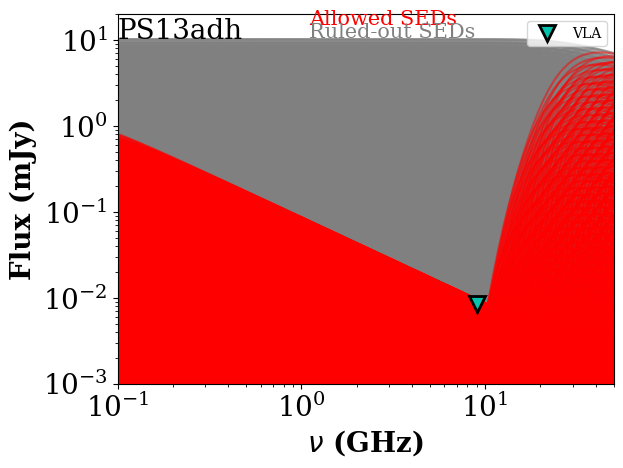

In [7]:
file_in = f'{SN_name}.csv' #R4_vlassbright.csv
data_plot = ascii.read(file_in)

plt.rcParams["font.family"] = "serif"
plt.rcParams.update({'font.size': 20})
plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=20)

#Not Allowed
index = np.where(data_plot['RuledOut'] == 'True')[0]
data_plot1 = data_plot[index]

##overplot the SEDs with v_shock < 20,000km/s
Fcalc = data_plot1['F_peak']#[data_plot1['v_shock'] <= 100000]
nucalc = data_plot1['nu_peak']#[data_plot1['v_shock'] <= 100000]
nu_sed=np.logspace(np.log10(0.1),np.log10(50),num=100)

###Cycle over the SEDs to show######
for i in range(len(Fcalc)):
   #calculate SSA
    SSA_sed = F_nu(t_p,nucalc[i],Fcalc[i],nu_sed)
    
    #calculate Mass loss rate, Radius, velocity, etc.
    R,B,E,v,M = SSA_props(t_p,nucalc[i],Fcalc[i],D_L)

    #calculate tau_ff
    tauff = taufreefree(M,R,nu_sed)
        
    #Correct SED for FFA:
    SSA_FFA_sed = SSA_sed*np.exp(-tauff)
    
    #Plot it:
    plt.plot(nu_sed,SSA_FFA_sed,'gray',zorder=1,alpha=0.5)

#Allowed
##overplot the SEDs with v_shock < 20,000km/s
indexa = np.where(data_plot['RuledOut'] == 'False')[0]
data_plota = data_plot[indexa]

Fcalc_v = data_plota['F_peak']#[data_plota['v_shock'] <= 100000]
nucalc_v = data_plota['nu_peak']#[data_plota['v_shock'] <= 100000]
nu_sed=np.logspace(np.log10(0.1),np.log10(50),num=100)

###Cycle over the SEDs to show######
for i in range(len(Fcalc_v)):
    #calculate SSA
    SSA_sedv = F_nu(t_p,nucalc_v[i],Fcalc_v[i],nu_sed)
    
    #calculate Mass loss rate, Radius, velocity, etc.
    Ra,Ba,Ea,va,Ma = SSA_props(t_p,nucalc_v[i],Fcalc_v[i],D_L)

    #calculate tau_ff
    tauffv = taufreefree(Ma,Ra,nu_sed)
        
    #Correct SED for FFA:
    SSA_FFA_sedv = SSA_sedv*np.exp(-tauffv)
    
    #Plot it:
    plt.plot(nu_sed,SSA_FFA_sedv,'r',zorder=1,alpha=0.5)
    
#Overplot the data: 0.65149
plt.plot(9,F_ul,'v',color='xkcd:turquoise',markersize=12,markeredgecolor='k',markeredgewidth=2, label='VLA')

plt.text(1.1,15,'Allowed SEDs',color='r',fontsize =15)
plt.text(1.1,10.6,'Ruled-out SEDs',color='gray',fontsize =15)
plt.text(0.1,10.2,f'{SN_name}',color='k',fontsize =20)
plt.xscale('log')
plt.yscale('log')

plt.ylabel('Flux (mJy)', fontweight='bold', fontsize=20) 
plt.xlabel(r'$\nu$ (GHz)', fontweight='bold', fontsize=20) 
#subplots[0].title.set_fontsize(16) 
plt.ylim(0.001,20)
plt.xlim(0.1,50)
plt.legend(fontsize=10, loc = 'upper right')
plt.show()
#print(len(data_plota))
#print(len(data_plot1))
#plt.savefig("sn-ejecta.jpeg",dpi=300,bbox_inches='tight')